In [13]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [14]:
def create_data(num_facilities,num_customers):
    np.random.seed(42)
    H = np.random.randint(1,10,num_customers)
    I = np.random.randint(1,100,(num_customers,2))
    J = np.random.randint(1,100,(num_facilities,2))
    
    return H,I,J

In [15]:
def calculate_distance(num_facilities,num_customers,I,J):
    distances = np.zeros((num_customers,num_facilities))
    for i in range(num_customers):
        for j in range(num_facilities):
            distances[i,j] = np.linalg.norm(I[i]-J[j])
            
    return distances

In [16]:
def gurobi_solve(num_facilities,num_customers,p):
    H,I,J = create_data(num_facilities,num_customers)
    distances = calculate_distance(num_facilities,num_customers,I,J)
    m = gp.Model('PMP')

    #decision variable
    X = m.addVars(num_facilities, vtype=GRB.BINARY, name="X")
    Y = m.addVars(num_customers, num_facilities, vtype=GRB.BINARY, name="Y")

    # objective
    m.setObjective(gp.quicksum(H[i] * distances[i, j] * Y[i, j] for i in range(num_customers) for j in range(num_facilities)), GRB.MINIMIZE)

    #constraint
    m.addConstr(gp.quicksum(X[j] for j in range(num_facilities))==p)
    m.addConstrs(Y[i,j]<=X[j] for i in range(num_customers) for j in range(num_facilities))
    m.addConstrs(gp.quicksum(Y[i,j] for j in range(num_facilities))==1 for i in range(num_customers))

    m.optimize()

    return m,X,Y,I,J

In [17]:
def results_visualization(num_facilities,num_customers,model,X,Y,I,J):

    open_idx = []
    for i in range(num_facilities):
        if X[i].x == 1.0:
            open_idx.append(i)

    for i in range(num_facilities):
        if X[i].x == 1.0:
            plt.scatter(J[i][0],J[i][1],color='r')
            plt.text(J[i][0],J[i][1]+0.5,'facilities {}'.format(i))

    for i in range(num_customers):
        plt.scatter(I[i][0],I[i][1],color='b')
        plt.text(I[i][0],I[i][1]+0.5,'{}'.format(i))

    for i in range(num_customers):
        for j in open_idx:
            if Y[i,j].x == 1.0:
                plt.plot([I[i][0],J[j][0]],[I[i][1],J[j][1]],color='gray',alpha=0.3)

In [18]:
num_facilities = 10
num_customers = 50
p = 3

In [19]:
model,X,Y,I,J = gurobi_solve(num_facilities,num_customers,p)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 551 rows, 510 columns and 1510 nonzeros
Model fingerprint: 0x9e5a2ecc
Variable types: 0 continuous, 510 integer (510 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 14276.239566
Presolve time: 0.00s
Presolved: 551 rows, 510 columns, 1510 nonzeros
Variable types: 0 continuous, 510 integer (510 binary)
Found heuristic solution: objective 9881.9230199

Root relaxation: objective 6.969747e+03, 228 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

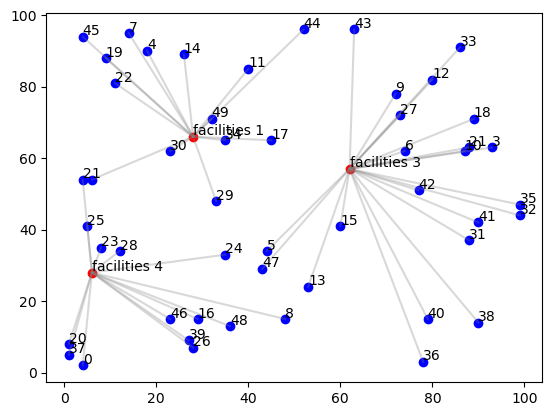

In [20]:
results_visualization(num_facilities,num_customers,model,X,Y,I,J)

In [21]:
def test2(num_facilities,num_customers,model,X,Y,I,J):

    open_idx = []
    for i in range(num_facilities):
        if X[i].x==1.0:
            open_idx.append(i)

    mapping = []
    for j in open_idx:
        for i in range(num_customers):
            if Y[i,j].x==1.0:
                mapping.append([i,j])
    
    for i in open_idx:
        plt.scatter(J[i][0],J[i][1],color='r',label='facility')
        plt.text(J[i][0],J[i][1]+3,'F{}'.format(i))

    for i in mapping:
        facility_idx = i[1]
        customer_idx = i[0]
        color = plt.cm.tab10(facility_idx)
        plt.scatter(I[customer_idx][0], I[customer_idx][1], color=color)
        plt.text(I[customer_idx][0], I[customer_idx][1],'c{}'.format(customer_idx),alpha=0.5)

    for k in mapping:
        i,j = k
        plt.plot([J[j][0],I[i][0]],[J[j][1],I[i][1]],color='gray',alpha=0.2)

    # legend
    legend_elements = []
    added_colors = set()
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10,
                                  label='Facility'))
    for i in mapping:
        facility_idx = i[1]
        if facility_idx not in added_colors:
            color = plt.cm.tab10(facility_idx)
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10,
                                          label='Customers receiving service from F{}'.format(facility_idx)))
            added_colors.add(facility_idx)
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.0,1.0))

    plt.title('< P-median gurobi > \n num_facilities:{}, num_customers:{}, p:{} \n objective: {}'.format(num_facilities,num_customers,p,model.objVal))

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.show()

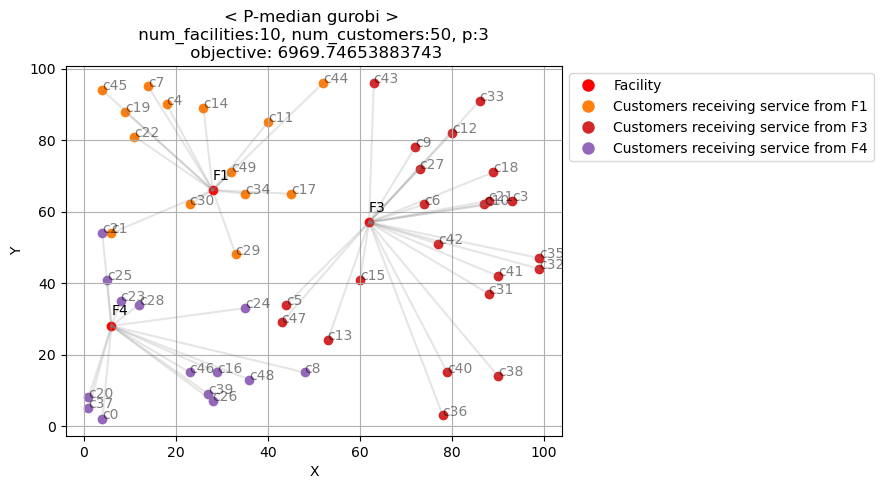

In [22]:
test2(num_facilities,num_customers,model,X,Y,I,J)

In [54]:
def data_size(start_f,end_f,start_c,end_c,p):
    f_idx = []
    c_idx = [i for i in range(start_c, end_c, 100)]
    time_list = []
    objectval = []
    gap = []
    for i in range(end_f,start_f-1,-1):
        f_idx.append(i)
        temp1 = []
        temp2 = []
        temp3 = []
        for j in range(start_c,end_c,100):
            m,X,Y,I,J=gurobi_solve(i,j,p)
            temp1.append(m.Runtime)
            if m.status != gp.GRB.OPTIMAL:
                temp2.append(-1)
                temp3.append(-1)
            else:
                temp2.append(m.MIPGap)
                temp3.append(m.objVal)
        time_list.append(temp1)
        gap.append(temp2)
        objectval.append(temp3)
    
    time_matrix = np.array(time_list)
    sns.heatmap(time_matrix, xticklabels=c_idx, yticklabels=f_idx, annot=True, fmt=".3f",cmap='YlGnBu',annot_kws={"size":8})
    plt.xlabel('num_customer')
    plt.ylabel('num_facility')
    plt.title('Heatmap of Time')
    plt.show()

    obj_matrix = np.array(objectval)
    sns.heatmap(obj_matrix, xticklabels=c_idx, yticklabels=f_idx, annot=True, fmt=".1f",cmap='YlGnBu',annot_kws={"size":6})
    plt.xlabel('num_customer')
    plt.ylabel('num_facility')
    plt.title('Heatmap of Objective')
    plt.show()

    gap_matrix = np.array(gap)
    sns.heatmap(gap_matrix, xticklabels=c_idx, yticklabels=f_idx, annot=True, fmt=".2f",annot_kws={"size":8})
    plt.xlabel('num_customer')
    plt.ylabel('num_facility')
    plt.title('Heatmap of Gap')
    plt.show()


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1101 rows, 1010 columns and 3010 nonzeros
Model fingerprint: 0x13cfc717
Variable types: 0 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 31074.127345
Presolve time: 0.00s
Presolved: 1101 rows, 1010 columns, 3010 nonzeros
Variable types: 0 continuous, 1010 integer (1010 binary)
Found heuristic solution: objective 18403.292156

Root relaxation: objective 1.083868e+04, 304 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

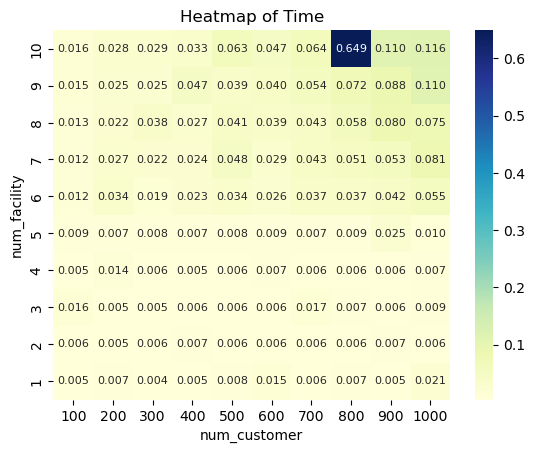

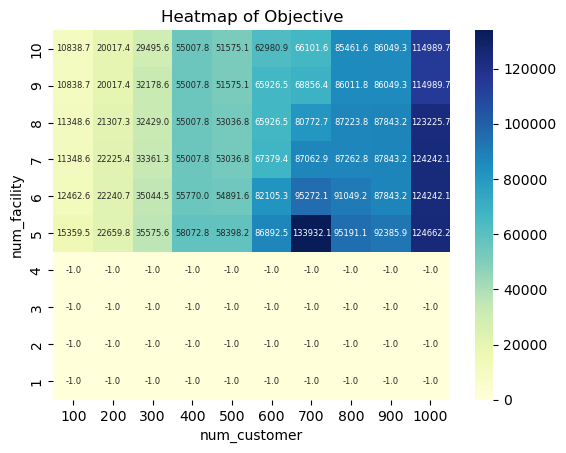

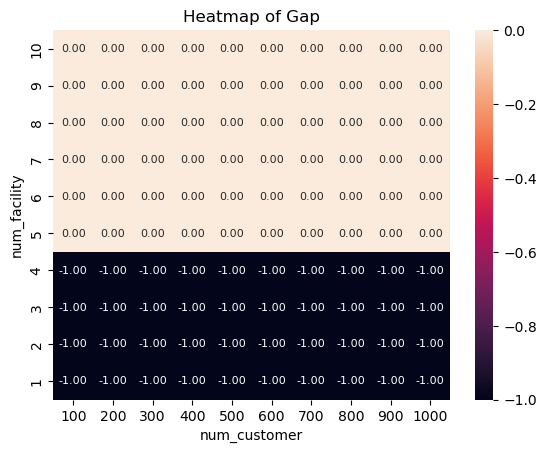

In [56]:
data_size(1,10,100,1001,5)